In [1]:
# Библиотеки
from __future__ import division, print_function
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [43]:
# Загрузим данные и объединим в один датафрейм
df = pd.read_csv("train.csv", encoding='ISO-8859-1', low_memory=False)

In [44]:
# Смотрим структуру данных
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [45]:
# Определеяем наличие пустых значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

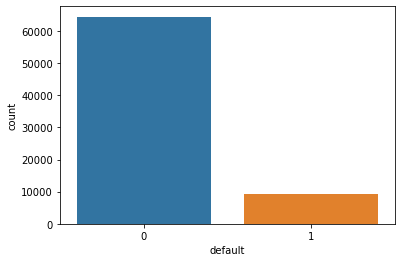

In [46]:
# Смотрим на распределение значений целевой переменной
sns.countplot(x='default', data=df)

In [47]:
#Для разбиения признаков по категориям посмотрим на уникальные значение признаков и их количество
df.agg({'nunique', lambda x: x.unique()}).transpose()

,<lambda>,nunique
client_id,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",73799
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120
education,"[SCH, GRD, UGR, PGR, ACD, nan]",5
sex,"[M, F]",2
age,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29, 32, 3...",52
car,"[Y, N]",2
car_type,"[Y, N]",2
decline_app_cnt,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9, 13, 11, 19, 10,...",21
good_work,"[0, 1]",2
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",69096


In [48]:
df['month'] = df['app_date'].apply(
    lambda x: datetime.strptime(x, '%d%b%Y').month)
df['weekd_or_workd'] = df['app_date'].apply(
    lambda x: 0 if (datetime.strptime(x, '%d%b%Y').weekday() < 5)
    and (datetime.strptime(x, '%d%b%Y').month == 1 and datetime.strptime(x, '%d%b%Y').day > 8)
    else 1)

In [70]:
# Распределим поля по группам
# Числовые поля
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
# Поля с бинарными значениями
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport', 'weekd_or_workd']
# Поля с категориальными значениями
cat_cols = ['home_address', 'work_address',
            'sna', 'region_rating', 'month', 'education']

In [50]:
def show_results(model):
    # Функция для отображения результатов

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(X_test)
    f1_val = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print('[valid] F1-score = {:.2f}'.format(f1_val))
    print('[valid] confusion_matrix: ')
    print(conf_matrix)


def df_split(X, y):
    # Функция для разбиения выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test

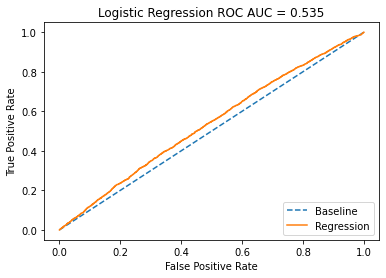

[valid] F1-score = 0.00
[valid] confusion_matrix: 
[[19229     0]
 [ 2819     0]]


In [51]:
# удалим пропуски и построим модель только по числовым значениям
df_ref = df.dropna()
X = df_ref[num_cols]
y = df_ref['default']

# Разобъем выборку
X_train, X_test, y_train, y_test = df_split(X, y)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

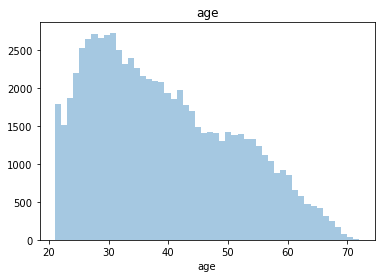

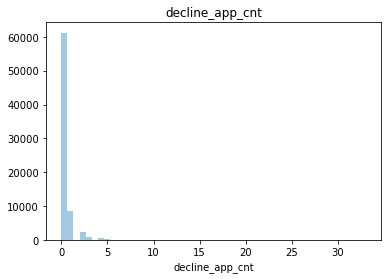

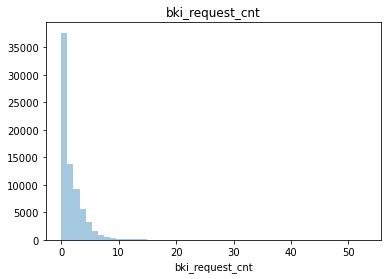

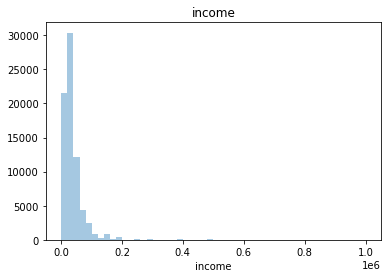

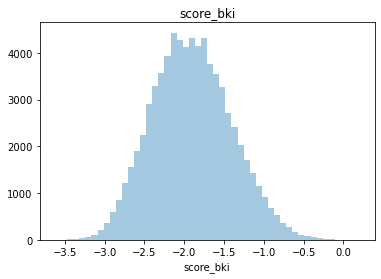

In [52]:
# Посмотрим на распределение значений числовых полей
for column in num_cols:
    plt.figure()
    sns.distplot(df[column], kde = False, rug=False)
    plt.title(column)
    plt.show()

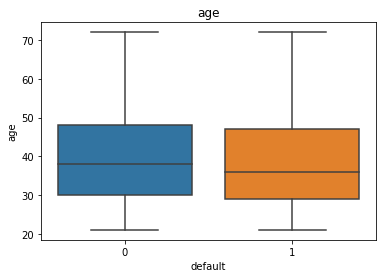

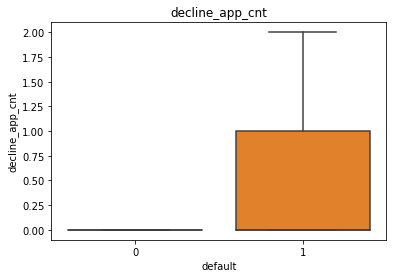

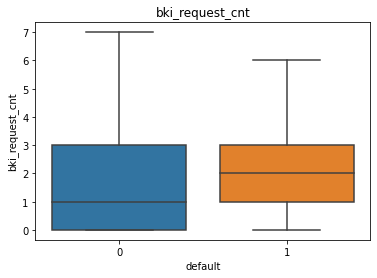

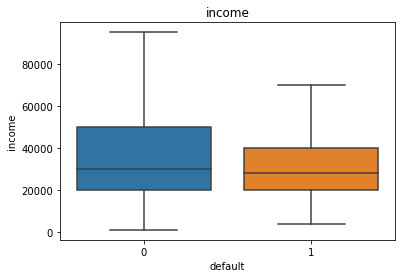

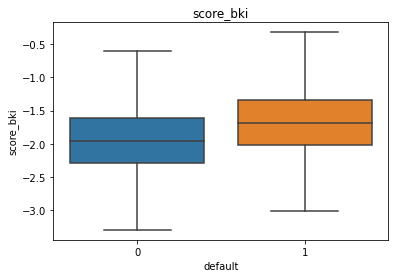

In [53]:
for i in num_cols:
    plt.figure()
    sns.boxplot(df['default'], df[i].dropna(), showfliers=False)
    plt.title(i)
    plt.show()

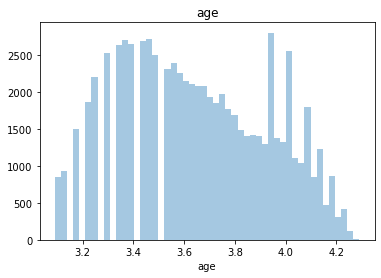

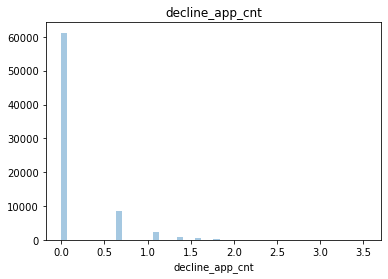

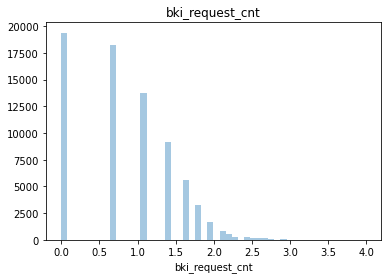

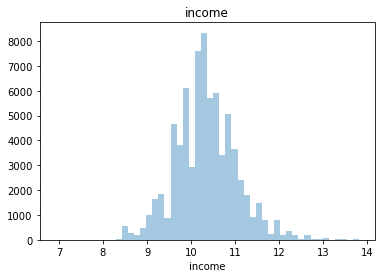

In [54]:
# Посмотрим на распределение значений числовых полей после применения логарифмирования
for i in num_cols[:-1]:
    plt.figure()
    sns.distplot(np.log(df[i]+1), kde = False, rug=False)
    plt.title(i)
    plt.show()

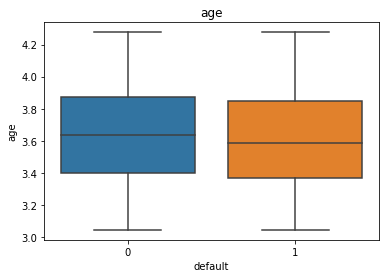

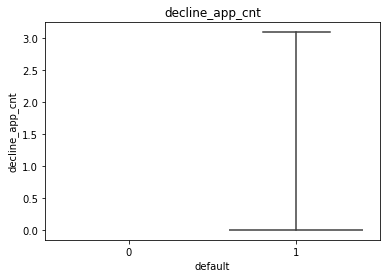

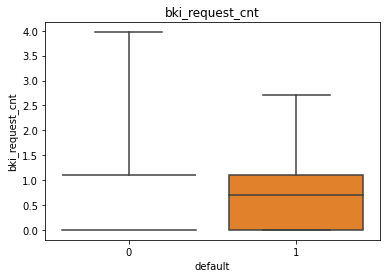

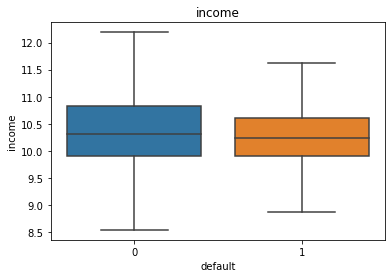

In [55]:
for i in num_cols[:-1]:
    plt.figure()
    sns.boxplot(df['default'], np.log(
        df[i]), showfliers=False)
    plt.title(i)
    plt.show()

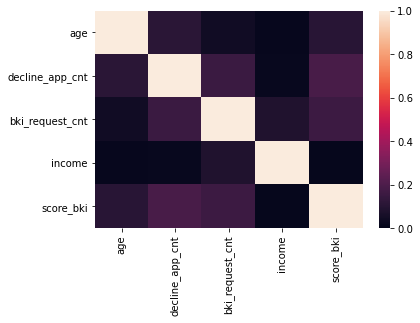

In [56]:
# Посмотрим корреляции
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

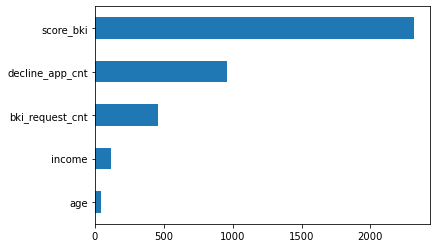

In [57]:
# Оценим важность числовых переменных
imp_num = Series(f_classif(df_ref[num_cols], df_ref['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [58]:
# Проверим данные после логарифмирования
df_ref_log = df_ref[num_cols[:-1]]
for c in [c for c in df_ref_log.columns if df_ref_log[c].dtype in numerics]:
    df_ref_log[c] = np.log(df_ref_log[c][df_ref_log[c] > 0].dropna())

df_ref_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73492 entries, 0 to 73798
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              73492 non-null  float64
 1   decline_app_cnt  12561 non-null  float64
 2   bki_request_cnt  54210 non-null  float64
 3   income           73492 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


Выводы:
    Распределение числовых признаков стало более близко к нормальному
    Применять логарифмирование можно только к полям 'age' и 'income'

In [59]:
num_log = ['age', 'income']

for c in num_log:
    df_ref[c] = np.log(df_ref[c])

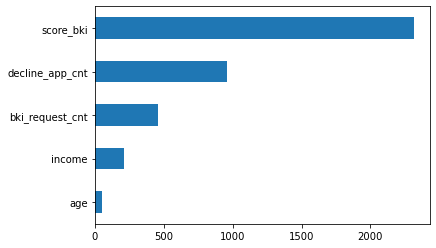

In [60]:
# Оценим важность числовых переменных
imp_num = Series(f_classif(df_ref[num_cols], df_ref['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

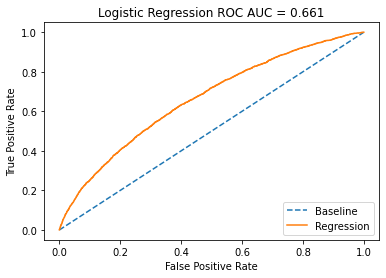

[valid] F1-score = 0.02
[valid] confusion_matrix: 
[[19187    42]
 [ 2786    33]]


In [61]:
# Посмотрим на поведение модели после логарифмизации числовых признаков
X = df_ref[num_cols]
y = df_ref['default']

# Разобъем выборку
X_train, X_test, y_train, y_test = df_split(X, y)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

Логарифмирование полей улучшило предсказательные возможности модели

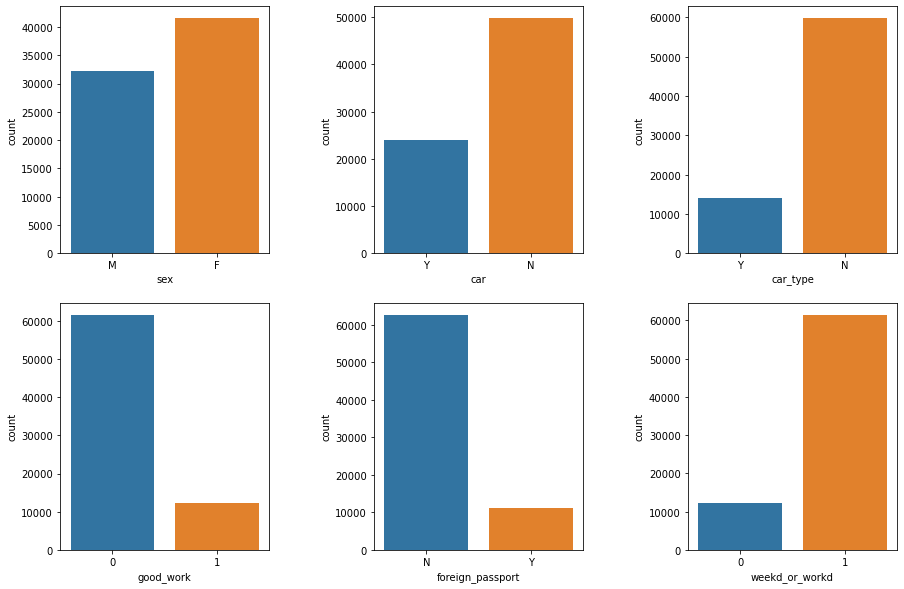

In [62]:
# Добавим в модель бинарные признаки
fig,axes = plt.subplots(2, 3, figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(bin_cols)):
    sns.countplot(x=bin_cols[i], data=df, ax=axes[i])

In [63]:
# Для бинарных признаков используем LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df_ref[column] = label_encoder.fit_transform(df_ref[column])

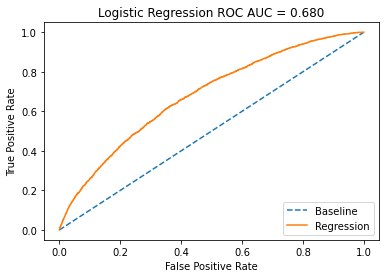

[valid] F1-score = 0.03
[valid] confusion_matrix: 
[[19182    47]
 [ 2779    40]]


In [64]:
X = np.hstack([df_ref[num_cols].values, df_ref[bin_cols].values])
y = df_ref['default']

# Разобъем выборку
X_train, X_test, y_train, y_test = df_split(X, y)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

Добавление бинарных признаков немного улучшило модель

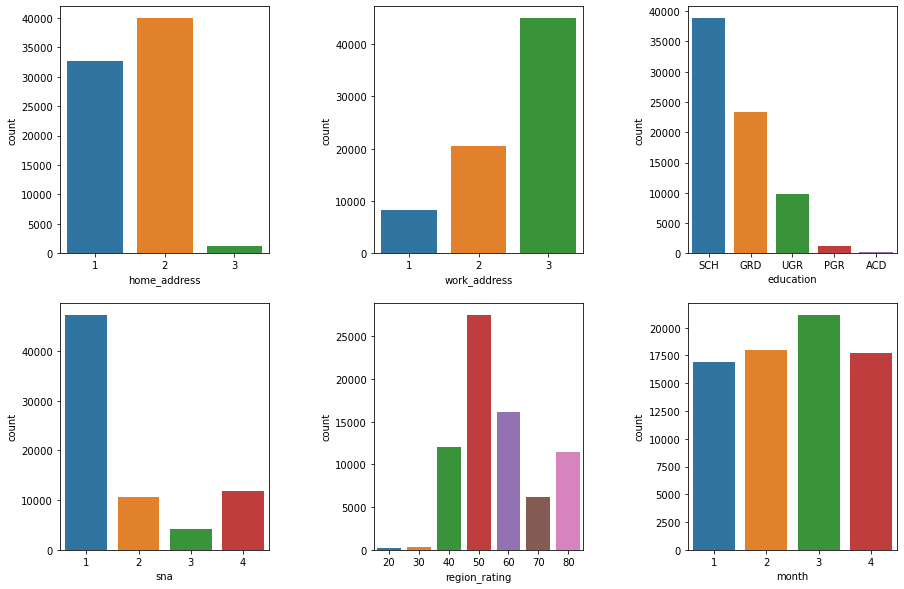

In [65]:
# Перейдем к категориальным признакам на полном датасете
fig,axes = plt.subplots(2, 3, figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.countplot(x=cat_cols[i], data=df, ax=axes[i])

In [66]:
# Заполним пропуски в поле 'education' на моду
mode = df['education'].mode()
df['education'] = df['education'].fillna(mode[0])

In [67]:
# Проведем преобразования для полного датасета
for c in num_log:
    df[c] = np.log(df[c])
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

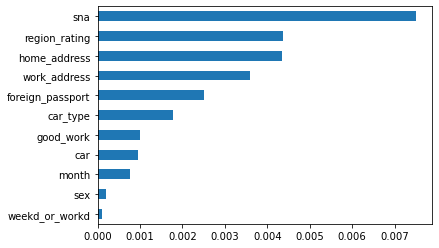

In [71]:
# Оценим важность не числовых переменных
# Временно уберем поле Education из списка категориальных переменных']
imp_cat = Series(mutual_info_classif(
    df[bin_cols + cat_cols[:-1]], df['default'], discrete_features=True), index=bin_cols + cat_cols[:-1])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [72]:
# Сформируем dummy-переменные для категориальных переменных
X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_cols].values)

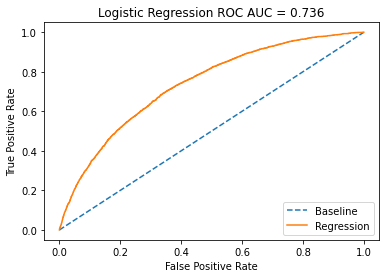

[valid] F1-score = 0.05
[valid] confusion_matrix: 
[[19258   102]
 [ 2709    71]]


In [73]:
# Посмотрим результат
X = np.hstack([df[num_cols].values, df[bin_cols].values, X_cat])
y = df['default']

# Разобъем выборку
X_train, X_test, y_train, y_test = df_split(X, y)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

Модель стала еще лучше

In [74]:
# Стандартизуем числовые переменные
X_num = StandardScaler().fit_transform(df[num_cols].values)

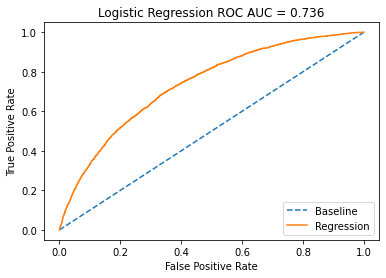

[valid] F1-score = 0.05
[valid] confusion_matrix: 
[[19258   102]
 [ 2709    71]]


In [75]:
# Посмотрим результат
X = np.hstack([X_num, df[bin_cols].values, X_cat])
y = df['default']

# Разобъем выборку
X_train, X_test, y_train, y_test = df_split(X, y)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

Лучшее Penalty: l2
Лучшее C: 7.742636826811269


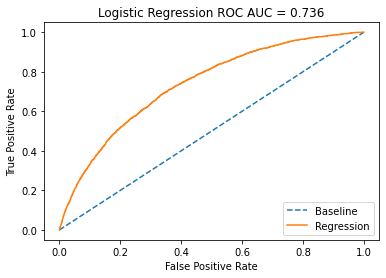

[valid] F1-score = 0.05
[valid] confusion_matrix: 
[[19257   103]
 [ 2709    71]]


In [76]:
# Поищем оптимальные гипер-параметы

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression().fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

# Выведем результат
show_results(best_model)

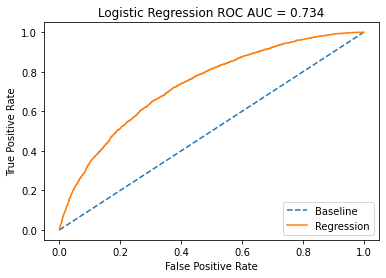

[valid] F1-score = 0.05
[valid] confusion_matrix: 
[[19243    85]
 [ 2737    75]]


In [77]:
# Попробуем простой over-sampling
# Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

over-sampling помог улуччшить прогноз по дефолтным клиентам

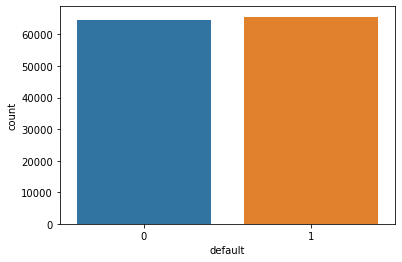

In [78]:
# Попробуем over-sampling копированием
data_default = df[df.default == 1]
df = pd.concat([df, data_default, data_default, data_default, data_default, data_default, data_default])
sns.countplot(x='default', data=df)

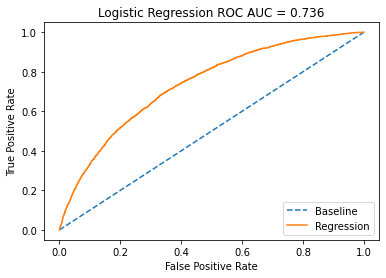

[valid] F1-score = 0.05
[valid] confusion_matrix: 
[[19258   102]
 [ 2709    71]]


In [79]:
# Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
show_results(model)

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
model = LogisticRegression(random_state=42)
C = np.logspace(-1, 4, 15)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}
    ]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
best_parameters

{'C': 2.682695795279726,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag',
 'tol': 0.001,
 'verbose': 0,
 'warm_start': False}

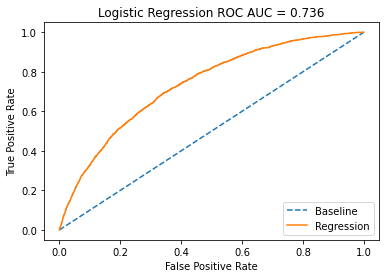

[valid] F1-score = 0.34
[valid] confusion_matrix: 
[[12993  6367]
 [  901  1879]]


In [83]:
# Выведем результат
show_results(model)

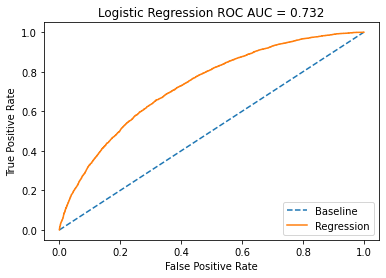

[valid] F1-score = 0.67
[valid] confusion_matrix: 
[[8621 4302]
 [4275 8573]]


In [37]:
# Загрузим данные и объединим в один датафрейм
data1 = pd.read_csv("train.csv", encoding='ISO-8859-1', low_memory=False)
data2 = pd.read_csv("test.csv", encoding='ISO-8859-1', low_memory=False)
df = pd.concat([data1, data2])

# Обработаем поле с датами
df['month'] = df['app_date'].apply(
    lambda x: datetime.strptime(x, '%d%b%Y').month)
df['weekd_or_workd'] = df['app_date'].apply(
    lambda x: 0 if (datetime.strptime(x, '%d%b%Y').weekday() < 5)
    and (datetime.strptime(x, '%d%b%Y').month == 1 and datetime.strptime(x, '%d%b%Y').day > 8)
    else 1)
df.drop(['app_date'], axis=1, inplace=True)

# Разделим поля по категориям
# Числовые поля
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'income']
# Поля с бинарными значениями
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport', 'weekd_or_workd']
# Поля с категориальными значениями
cat_cols = ['home_address', 'work_address',
            'sna', 'region_rating', 'month', 'education']

# Выполним преобразования для столбца 'income'
# Находим среднее значение по городам
min_income_log = df.groupby(by='region_rating')['income'].min()

# Находим стандартное отклонение значений Ranking по городам
max_income_log = df.groupby(by='region_rating')['income'].max()

# Добавляем колоки в наш датафрейм с этими значениями относительно каждого города
df['min_income'] = df['region_rating'].apply(lambda x: min_income_log[x])
df['max_income'] = df['region_rating'].apply(lambda x: max_income_log[x])

# Выполняем нормализацию Ranking в новый столбец
df['income'] = (df['income'] - df['min_income']) / \
    (df['max_income']-df['min_income'])

# Произведем лог-преобразования со всеми числовыми признаками, кроме 'income' и 'score_bki'
for column in num_cols[:-2]:
    df[column] = np.log(df[column] + 1)

# Для бинарных признаков используем LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# Заполним пропуски в поле 'education' на моду
mode = df['education'].mode()
df['education'] = df['education'].fillna(mode[0])

# Разделим данные на train и test
train_data = df[df['default'].isna() == False]
test_data = df[df['default'].isna() == True]

# Сделаем over-sampling тренировочной части
num_0 = len(train_data[train_data['default'] == 0])
num_1 = len(train_data[train_data['default'] == 1])
train_data = pd.concat([train_data[train_data['default'] == 0],
                        train_data[train_data['default'] == 1].sample(num_0, replace=True)])

# dummy-кодирование категориальных переменных
X_cat_train = OneHotEncoder(sparse=False).fit_transform(
    train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(
    test_data[cat_cols].values)

# Нормирование числовых признаков с помощью StandartScaler
scaler = StandardScaler()
X_num_train = scaler.fit_transform(train_data[num_cols].values)
X_num_test = scaler.transform(test_data[num_cols].values)

# Объединим все данные
X_train = np.hstack([X_num_train, train_data[num_cols[0:1]
                                             ].values, train_data[bin_cols].values, X_cat_train])
X_test = np.hstack([X_num_test, test_data[num_cols[0:1]].values,
                    test_data[bin_cols].values, X_cat_test])
y_train = train_data['default'].values

# Разделим данные для обучения следующим образом:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

# Обучим модель с использованием логистической регрессии
model = LogisticRegression().fit(X_train, y_train)

# Выведем результат
probs = model.predict_proba(X_valid)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

y_pred = model.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print('[valid] F1-score = {:.2f}'.format(f1_val))
print('[valid] confusion_matrix: ')
print(conf_matrix)